![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)

<br>

# Wind Chill Index with Reanalysis Data

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-climate-indices/main?labpath=ci-windchill.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-climate-indices/blob/main/ci-windchill.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-climate-indices/blob/main/ci-windchill.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-climate-indices/blob/main/ci-windchill.ipynb)


![logo](./img/climate_indices.png)



## Learning Objectives

This tutorial will demonstrate how to combine multiple variables of climate data to create an index. The example provided is of the wind speed index, but similar principles can be applied to many other types of single or multi-variable indices.

The data is provided by Copernicus Climate Change Service (C3S) and includes regional climate reanalysis data (UERRA) of wind speed and temperature over Europe from 1961 to 2019.

The tutorial will first show how to download the necessary data from the C3S Climate Data Store (CDS). It will then describe how to apply a commonly used Wind Chill Index formula to the data, and finally plot a map of the wind chill climatology for a particular day over Europe.

The steps shown in this tutorial can be applied to other climate datasets, such as the 5th version of the ECMWF Reanalysis (ERA5), or other data.

<hr>

## Prepare your environment

### Set up the CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [ ]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

### Specify data directory

In [ ]:
# Directory to store data
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

<hr>

## Explore Data

The wind chill index we will calculate takes two parameters as input, these are 2m near-surface air temperature, and 10m wind speed. Data for these parameters are available as part of the UERRA regional reanalysis dataset for Europe for the period 1961 to 2019. We will search for this data on the CDS website: http://cds.climate.copernicus.eu. The specific dataset we will use is the `UERRA regional reanalysis for Europe on single levels from 1961 to 2019`. 

### Search for the Data

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

<details>
  <summary><strong> Parameters of data to download</strong></summary>

- Origin: `UERRA-HARMONIE`
- Variable: `10m wind speed` and `2m temperature` (these will need to be selected one at a time)
- Year: `1989 to 2018`
- Month: `January`
- Day: `15`
- Time: `06:00`
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below). Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory.

*Please note that text below will appear in a warning box when rendered on the JupyterBook html pages*

:warning: Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form!

> **Note:** UERRA data are stored on tapes in MARS, the ECMWF Meteorological Archival and Retrieval System. Accessing data from tapes is generally slower than accessing data directly from disk. The data requests below may take some hours to complete. For a quicker response you can replace the UERRA data request with similar download parameters for lower resolution ERA5 global reanalysis datasets.

### Download the Data

With the API request copied into the cell below, running this cell will retrieve and download the data you requested into your local directory.

In [ ]:
c = cdsapi.Client()
c.retrieve(
    'reanalysis-uerra-europe-single-levels',
    {
        'origin': 'uerra_harmonie',
        'variable': '10m_wind_speed',
        'year': [
            '1989', '1990', '1991',
            '1992', '1993', '1994',
            '1995', '1996', '1997',
            '1998', '1999', '2000',
            '2001', '2002', '2003',
            '2004', '2005', '2006',
            '2007', '2008', '2009',
            '2010', '2011', '2012',
            '2013', '2014', '2015',
            '2016', '2017', '2018',
        ],
        'month': '01',
        'day': '15',
        'time': '06:00',
        'data_format': 'netcdf_legacy',
    },
    f'{DATADIR}UERRA_ws10m.nc')

In [ ]:
c = cdsapi.Client()
c.retrieve(
    'reanalysis-uerra-europe-single-levels',
    {
        'origin': 'uerra_harmonie',
        'variable': '2m_temperature',
        'year': [
            '1989', '1990', '1991',
            '1992', '1993', '1994',
            '1995', '1996', '1997',
            '1998', '1999', '2000',
            '2001', '2002', '2003',
            '2004', '2005', '2006',
            '2007', '2008', '2009',
            '2010', '2011', '2012',
            '2013', '2014', '2015',
            '2016', '2017', '2018',
        ],
        'month': '01',
        'day': '15',
        'time': '06:00',
        'data_format': 'netcdf_legacy',
    },
    f'{DATADIR}UERRA_t2m.nc')

### Inspect Data

We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the Xarray library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) objects.

In [5]:
fw = 'UERRA_ws10m.nc'
ft = 'UERRA_t2m.nc'
# Create Xarray Dataset
dw = xr.open_dataset(fw)
dt = xr.open_dataset(ft)

Now we can query our newly created Xarray datasets ...

In [6]:
dw

<xarray.Dataset>
Dimensions:            (time: 21, y: 565, x: 565)
Coordinates:
  * time               (time) datetime64[ns] 1998-12-15T12:00:00 ... 2018-12-...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         (time) datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    si10               (time, y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2022-02-03T12:45 GRIB to CDM+CF via cfgrib-0.9.9...

We see that dw (dataset for wind speed) has one variable called **"si10"**. If you view the documentation for this dataset on the CDS you will see that this is the wind speed valid for a grid cell at the height of 10m above the surface. It is computed from both the zonal (u) and the meridional (v) wind components by $\sqrt{(u^{2} + v^{2})}$. The units are m/s.

The other dataset, dt (2m temperature), has a variable called **"t2m"**. According to the documentation on the CDS this is air temperature valid for a grid cell at the height of 2m above the surface, in units of Kelvin.

While an Xarray **dataset** may contain multiple variables, an Xarray **data array** holds a single multi-dimensional variable and its coordinates. To make the processing of the **si10** and **t2m** data easier, we will convert them into Xarray data arrays.

In [7]:
# Create Xarray Data Arrays
aw = dw['si10']
at = dt['t2m']

In [8]:
aw

<xarray.DataArray 'si10' (time: 21, y: 565, x: 565)>
[6703725 values with dtype=float32]
Coordinates:
  * time               (time) datetime64[ns] 1998-12-15T12:00:00 ... 2018-12-...
    step               timedelta64[ns] 00:00:00
    heightAboveGround  float64 10.0
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         (time) datetime64[ns] 1998-12-15T12:00:00 ... 2018-12-...
Dimensions without coordinates: y, x
Attributes:
    GRIB_paramId:                             207
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      319225
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            lambert
    GRIB_DxInMetres:                          11000.0
    GRIB_DyInMetres:                          11000.0
    GRIB_LaDInDegrees:                        48.0
    GRIB_Latin1InDegrees:                     48.0
    GRIB_Latin2InDegrees:                     48.0
    GRIB_LoVInDegrees:                        8.0
    GRIB_NV:                                  0
    GRIB_Nx:                                  565
    GRIB_Ny:                                  565
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           si10
    GRIB_gridDefinitionDescription:           Lambert conformal 
    GRIB_iScansNegatively:                    0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    1
    GRIB_latitudeOfFirstGridPointInDegrees:   17.612
    GRIB_latitudeOfSouthernPoleInDegrees:     0.0
    GRIB_longitudeOfFirstGridPointInDegrees:  341.68
    GRIB_longitudeOfSouthernPoleInDegrees:    0.0
    GRIB_missingValue:                        9999
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

Notice that the `longitude` variables in the Xarray Dataset and Data Array objects are in the range of `[0, 359.75]`. Let us convert them into a `[-180, 180]` grid:

In [9]:
aw['longitude'] = ((aw.longitude + 180) % 360) - 180
at['longitude'] = ((at.longitude + 180) % 360) - 180

<hr>

## Calculate wind chill index
The wind chill index is a metric in temperature-like units, e.g. Kelvin or °C, and represents the lowering of body temperature due to a combination of low temperature and wind.

Since 2001, Canada, the United States and the United Kingdom have implemented the new wind chill index which is defined with the following formula:

$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

where:
- $\textit{T}_{WC}$ = wind chill index
- $\textit{T}_{a}$ = air temperature in degrees Celsius
- $\upsilon$ = wind speed at 10 m standard anemometer height, in kilometres per hour

We will apply this formula on our data to calculate the wind chill index for a particular period of time over Europe.

To calculate $\textit{T}_{WC}$ we first have to ensure our data is in the right units. For the wind speed we need to convert from m/s to km/h, and for air temperature we need to convert from Kelvin to degrees Celsius:

In [10]:
# wind speed, convert from m/s to km/h: si10 * 1000 / (60*60)
w = aw * 3600 / 1000
# air temperature, convert from Kelvin to Celsius: t2m - 273.15
t = at - 273.15

Now we can calculate the North American and United Kingdom wind chill index:
$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

In [11]:
twc = 13.12 + (0.6215*t) - (11.37*(w**0.16)) + (0.3965*t*(w**0.16))

Let's calculate the average wind chill for 06:00 on 15 January for the 30 year period from 1989 to 2018:

In [13]:
twc_mean = twc.mean(dim='time')

Before we plot the results, let's take the same European subset as that used for the [C3S Climate Bulletins](https://climate.copernicus.eu/climate-bulletins).

In [14]:
twc_mean_sub = twc_mean.where((twc_mean.latitude < 72) & 
                              (twc_mean.latitude > 34) & 
                              (twc_mean.longitude < 40) & 
                              (twc_mean.longitude > -25), drop=True)

Now let's plot the average wind chill for this time over Europe:

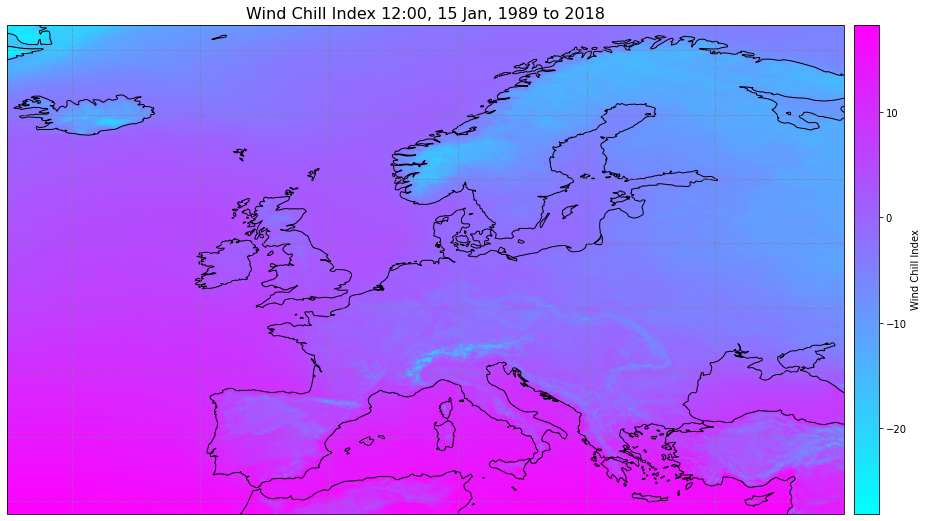

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (18, 9), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

im = plt.pcolormesh(twc_mean_sub.longitude, twc_mean_sub.latitude, twc_mean_sub, cmap='cool') 

ax.set_title('Wind Chill Index 12:00, 15 Jan, 1989 to 2018', fontsize=16)
ax.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.coastlines(color='black')
ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())

cbar = plt.colorbar(im,fraction=0.04, pad=0.01)
cbar.set_label('Wind Chill Index') 

fig.savefig(f'{DATADIR}UERRA_wind_chill_index_midJan.png')

Under which category of the wind chill index do the coldest areas in Europe generally lie at this time (see chart below)?

![logo](./img/Windchill_effect_en.png)

RicHard-59, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons

## Exercise: Repeat process with ERA5 data and compare results

So far you have plotted wind chill using the UERRA regional reanalysis dataset, but how accurate is this plot? One way to assess a dataset is to compare it with an alternative independent one to see what differences there may be. An alternative to UERRA is the ECMWF Reanalysis datasets, ERA5 (currently in it's 5th version). Repeat the steps above with ERA5 data and compare your results with those obtained using UERRA.

<hr>